In [1]:
from skimage import io
import scipy.ndimage as ndi
import random
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, jaccard_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import dice

from pathlib import Path
import os

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve

In [3]:
data_dir = "/users/shrey2/Documents/NDD/brainlit/docs/notebooks/utils/data"
print(f"Downloading segments to {data_dir}")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

im_dir = Path(os.path.join(data_dir, "sample-tif-location"))
if not os.path.exists(im_dir):
    os.makedirs(im_dir)

swc_dir = os.path.join(data_dir, "sample-swc-location")
if not os.path.exists(swc_dir):
    os.makedirs(swc_dir)

mask_dir = Path(os.path.join(data_dir, "mask-location"))

swc_base_path = Path(swc_dir) / "Manual-GT"

gfp_files = list(im_dir.glob("**/*-gfp.tif"))

ms = ""

In [4]:
X_torch = []
y_torch = []

for i, im_path in enumerate(tqdm(gfp_files)):

    f = im_path.parts[-1][:-8].split("_")
    image = f[0]
    num = int(f[1])

    if (image == "test" and num in [9,10,24]) or (image == "validation" and num in [11]):
        continue

    #getting image
    im = io.imread(im_path, plugin="tifffile")
    im = (im - np.amin(im)) / (np.amax(im) - np.amin(im))
    im = np.swapaxes(im,0,2)
    im_padded = np.pad(im, ((4,4), (4,4), (3,3)) )
    
    #getting ground truth mask
    file_name = str(im_path)[str(im_path).find("\\", 80) + 1 : (str(im_path).find("sample"))] + "/mask-location/"
    file_num = file_name[file_name.find("_")+1:]
    if file_name[0] == 'v':
        file_num = str(int(file_num)+25)
    mask_path = Path(file_name + f[0] + "_" + f[1] + "_mask.npy")
    mask = np.load(mask_path)
    
    X_torch.append(im)
    y_torch.append(mask)

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
X_torch = np.reshape(X_torch, (1, 46, 330, 330, 100)) #making it 5 channels for the 3d cnn
y_torch = np.reshape(y_torch, (1, 46, 330, 330, 100))

X_torch_train = X_torch[:, 0:23] #50/50 train test split
y_torch_train = y_torch[:, 0:23]
x_torch_test = X_torch[:, 23:46]
y_torch_test = y_torch[:, 23:46]

In [6]:
training_data = torch.tensor([X_torch_train, y_torch_train]).float()
test_data = torch.tensor([x_torch_test, y_torch_test]).float()

batch_size = 2

In [7]:
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Feature batch shape: torch.Size([1, 23, 330, 330, 100])
Labels batch shape: torch.Size([1, 23, 330, 330, 100])
Using cpu device


## Pytorch Model

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv3d(1, 1, kernel_size = 3, stride = 1, padding = 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        self.Sigmoid = nn.Sigmoid()
        logits = self.Sigmoid(logits)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
)


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    y_true = []
    y_pred = []
    for batch, (X_all, y_all) in enumerate(dataloader):
        
        loss_list = []

        for image in range(X_all.shape[1]):
            X = np.reshape(X_all[0][image], (1, 1, 330, 330, 100))
            y = np.reshape(y_all[0][image], (1, 1, 330, 330, 100))
            
            # Compute prediction and loss
            optimizer.zero_grad()
            pred = model(X)
            pred = torch.squeeze(pred, 3).clone()
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            loss, current = loss.item(), batch * len(X)
            loss_list.append(loss)
            
        print("Avg loss:", np.average(loss_list))


def test_loop(dataloader, model, loss_fn, print_acc):
    size = 330*330*100*14
    print("Size: ", size)
    num_batches = len(dataloader)
    
    for batch, (X_all, y_all) in enumerate(dataloader):

        test_loss, correct = 0, 0

        y_true = []
        y_pred = []
        y_list = []
        x_list = []

        with torch.no_grad():
            for image in range(X_all.shape[1]):
                X = np.reshape(X_all[0][image], (1, 1, 330, 330, 100))
                y = np.reshape(y_all[0][image], (1, 1, 330, 330, 100))
                pred = model(X)
                pred = torch.squeeze(pred, 3)
                
                x_list.append(X)
                y_list.append(y)
                y_pred.append(pred)
                
                test_loss += loss_fn(pred, y).item()
    
    #test acc
  #  if print_acc == True:
  #      acc_list = []
  #      i = 0
  #      while i < len(y_pred):
  #          pred_r = np.round(y_pred[i].detach().numpy()).flatten()
  #          target = np.array(y_list[i]).astype(int).flatten()
  #          acc = accuracy_score(pred_r, target)
  #          acc_list.append(acc)
        
        #pred_r = np.round(y_pred.flatten().detach())
        #target = np.array(y_list).flatten().astype(int)
        #pred_r = np.round(pred.detach().numpy()).flatten()
        #target = np.array(y).astype(int).flatten()
        #acc = accuracy_score(pred_r, target)
  #      print("Test accuracy: ", np.mean(acc_list))
    
    return x_list, y_pred, y_list, test_loss


In [11]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [14]:
#weights = torch.tensor([.75, .25])
#from torchgeometry.losses.dice import DiceLoss

#loss_fn = nn.BCELoss()
loss_fn = DiceLoss()
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 10

pred_list = []
y_list = []
loss_list = []


for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    if (epochs % 5 == 0):
        print_acc = True
    else:
        print_acc = False
    x_list, y_pred, y, loss = test_loop(test_dataloader, model, loss_fn, print_acc)
    pred_list.append(y_pred)
    y_list.append(y)
    loss_list.append(loss)
print("Done!")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Avg loss: 0.9937952756881714
Size:  152460000
Epoch 2
-------------------------------
Avg loss: 0.993795273096665
Size:  152460000
Epoch 3
-------------------------------
Avg loss: 0.993795273096665
Size:  152460000
Epoch 4
-------------------------------
Avg loss: 0.9937952705051588
Size:  152460000
Epoch 5
-------------------------------
Avg loss: 0.9937952705051588
Size:  152460000
Epoch 6
-------------------------------
Avg loss: 0.9937952679136525
Size:  152460000
Epoch 7
-------------------------------
Avg loss: 0.9937952679136525
Size:  152460000
Epoch 8
-------------------------------
Avg loss: 0.9937952627306399
Size:  152460000
Epoch 9
-------------------------------
Avg loss: 0.9937952601391337
Size:  152460000
Epoch 10
-------------------------------
Avg loss: 0.9937952601391337
Size:  152460000
Done!


In [15]:
# getting accuracy, precision, recall at each epoch

acc_list = []
precision_list = []
recall_list = []

for i in tqdm(range(len(pred_list))):
    acc_list_t = []
    precision_list_t = []
    recall_list_t = []
    
    for j in tqdm(range(len(pred_list[0]))):
        pred = pred_list[i][j].clone().numpy()[:, 0].round().astype(int).flatten()
        target = y_list[i][j][:, 0].clone().numpy().astype(int).flatten()

        acc = accuracy_score(target, pred) * 100
        acc_list_t.append(acc)

        pr = precision_score(target, pred) * 100
        precision_list_t.append(pr)

        rc = recall_score(target, pred) * 100
        recall_list_t.append(rc)
        
    mean_acc = np.mean(acc_list_t)
    mean_pr = np.mean(precision_list_t)
    mean_rc = np.mean(recall_list_t)
    
    acc_list.append(mean_acc)
    precision_list.append(mean_pr)
    recall_list.append(mean_rc)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
# Quick test stats

def get_stats(stat, epoch, acc_list, precision_list, recall_list):
    if stat == "accuracy":
        print("Accuracy at epoch " + str(epoch) + " is " + str(acc_list[epoch - 1]))
    if stat == "all":
        print("Accuracy at epoch " + str(epoch) + " is " + str(acc_list[epoch - 1]))
        print("Precision at epoch " + str(epoch) + " is " + str(precision_list[epoch - 1]))
        print("Recall at epoch " + str(epoch) + " is " + str(recall_list[epoch - 1]))
        
get_stats("all", 2, acc_list, precision_list, recall_list)

In [ ]:
plt.figure()
plt.title("Test loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.plot(loss_list)

plt.figure()
plt.title("Accuracy over epoch")
plt.xlabel("Epoch")
plt.ylabel("Avg accuracy (%)")
plt.plot(acc_list)

plt.figure()
plt.title("Precision over epoch")
plt.xlabel("Epoch")
plt.ylabel("Avg precision (%)")
plt.plot(precision_list)

plt.figure()
plt.title("Recall over epoch")
plt.xlabel("Epoch")
plt.ylabel("Avg recall (%)")
plt.plot(recall_list)

In [ ]:
acc_list_t

In [ ]:
# Accuracy histogram on last epoch

plt.figure()
plt.title("Accuracy histogram for individual 23 images on last epoch")
plt.ylabel("Individual Accuracy")
plt.hist(acc_list_t, bins = 20)

In [13]:
# Plot all images/predictions from last epoch

from sklearn.metrics import roc_curve, precision_recall_curve, auc

for i in range(len(y_list[len(y_list) - 1])):
    x = x_list[i].clone()[:,0].numpy()
    pred = pred_list[len(pred_list) - 1][i].clone()[:,0].numpy()
    y = y_list[len(y_list) - 1][i].clone()[:,0].numpy()
    
    fpr, tpr, thresholds = roc_curve(y.flatten(), pred.flatten())
    optimal_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Optimal Threshold for image " + str(i) + ": ", optimal_thresh)
    
    pred_thresh = pred
    
    for i in range(1):
        for a in range(330):
            for b in range(330):
                for c in range(100):
                    if pred[i][a][b][c]  > optimal_thresh:
                        pred_thresh[i][a][b][c] = 1
                    else:
                        pred_thresh[i][a][b][c] = 0


    import napari
    with napari.gui_qt():
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(x[0])
        viewer.add_labels(y[0].astype(int))
        viewer.add_labels(pred_thresh[0].astype(int), num_colors = 2)
    
    

Optimal Threshold for image 0:  0.4813292
Optimal Threshold for image 1:  0.48879603


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 2:  0.48569155


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(161, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(161, 1)>
Traceback (most recent call last):
  File "/Users/shrey2/opt/anacon

Optimal Threshold for image 3:  0.48149103


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(200, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(200, 1)>
Traceback (most recent call last):
  File "/Users/shrey2/opt/anacon

Optimal Threshold for image 4:  0.48195323


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 5:  0.4820033


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 6:  0.48155692


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 7:  0.48152474


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 8:  0.4880304


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 9:  0.48267302


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 10:  0.4855357


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 11:  0.48116392


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(512, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(512, 1)>
Traceback (most recent call last):
  File "/Users/shrey2/opt/anacon

Optimal Threshold for image 12:  0.48119318


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(551, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(551, 1)>
Traceback (most recent call last):
  File "/Users/shrey2/opt/anacon

Optimal Threshold for image 13:  0.48149678


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 14:  0.48900756


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 15:  0.4819097


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(668, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(668, 1)>
Traceback (most recent call last):
  File "/Users/shrey2/opt/anacon

Optimal Threshold for image 16:  0.48162946


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 17:  0.48406285


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 18:  0.48327488


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 19:  0.4841251


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 20:  0.48557067
Optimal Threshold for image 21:  0.48140803


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

Optimal Threshold for image 22:  0.48226443


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/zmq/eventloop/

In [69]:
#metrics for one image

#pred_0 = pred.clone().numpy()[:, 0].round().astype(int).flatten()
#target_0 = y_torch_test[:, 0].astype(int).flatten()

#print("Accuracy: ", accuracy_score(target_0, pred_0) * 100)
#print("Precision: ", precision_score(target_0, pred_0) * 100)
#print("Recall: ", recall_score(target_0, pred_0) * 100)
#print("Nonzeros: ", np.count_nonzero(pred_0) * 100)
#print("Nonzeros percent: ", np.count_nonzero(pred_0) / len(target_0) * 100)

Optimal Threshold:  0.53039104


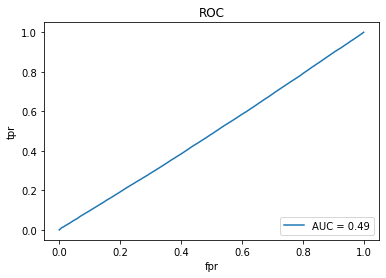

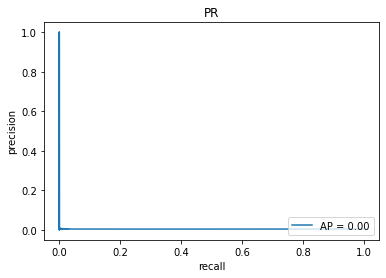

In [46]:
#PR and ROC Curves

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt


last_pred = pred_list[len(pred_list)-1][len(pred_list[0])-1].clone()
#last_pred = pred_list[len(pred_list)-2].clone()
y_torch_test_0 = y_torch_test[:, 0]

fpr, tpr, thresholds = roc_curve(y_torch_test_0.flatten(), last_pred.flatten())
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_torch_test_0.flatten(), last_pred.flatten())

#printing optimal ROC threshold
optimal_thresh = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold: ", optimal_thresh)

#plotting
plt.figure()
plt.title("ROC")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')

plt.figure()
plt.title("PR")
plt.xlabel("recall")
plt.ylabel("precision")
plt.plot(recall, precision, label = "AP = %0.2f" % np.mean(precision))
plt.legend(loc = 'lower right')


In [47]:
#thresholding for test image 0

#pred2 = pred_list[len(pred_list)-2].clone().detach()

#pred2 = pred.clone().detach()
#pred2_0 = pred2[:,0]

pred2_0 = last_pred[:,0]

predN0 = pred2_0.numpy()
#for i in range(predN.shape[0]):
for i in range(1):
    for a in range(330):
        for b in range(330):
            for c in range(100):
                if predN0[i][a][b][c]  > optimal_thresh:
                    predN0[i][a][b][c] = 1
                else:
                    predN0[i][a][b][c] = 0


In [49]:
import napari
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image((x_torch_test[0][22]))
    viewer.add_labels((y_torch_test[0][22]).astype(int))
    viewer.add_labels(predN0[0].astype(int), num_colors = 2)

/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/napari/_qt/qt_event_loop.py:256: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
